# Make of a neural network with numpy

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/tmp/ipykernel_14253/2080034654.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Using ndarrays as Tensors, adding the typing library to be more explicit and creating a new type "Func" which is a function taking a Tensor as argument and returning a Tensor

In [2]:
from numpy import ndarray as Tensor

from typing import (Dict, Tuple, Callable, 
                    Sequence, Iterator, NamedTuple)
Func = Callable[[Tensor], Tensor]

### Defining the Loss function to minimize

In [3]:
# Class constructiong a generic loss function

class Loss:
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        """ 
        Compute the loss between predictions and actual labels 
        """
        raise NotImplementedError

    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        """ 
        Compute the gradient for the backward pass 
        """
        raise NotImplementedError

# Mean square error loss

class MeanSquareError(Loss):
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        return np.sum((predicted - actual)**2) / len(actual)
    
    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return (2 * (predicted - actual)) / len(actual)
    
# Binary cross entropy loss

class BinCrossEntropy(Loss):
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        return - ((np.sum(actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted))) / len(actual))
    
    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return - (((actual / predicted) - ((1 - actual) / (1 - predicted))) / len(actual))


### Constructring the different layers with classes

In [4]:
# Class constructing a generic layer

class Layer:
    def __init__(self) -> None:

        # Store the parameters values and gradients in dictionnaries
        self.params: Dict[str, Tensor] = {}
        self.grads: Dict[str, Tensor] = {}

    def forward(self, inputs: Tensor) -> Tensor:
        raise NotImplementedError

    def backward(self, grad: Tensor) -> Tensor:
        raise NotImplementedError


# Class constructing a linear layer of neurons

class Linear(Layer):
    """
    Inputs are of size (batch_size, input_size)
    Outputs are of size (batch_size, output_size)
    """
    def __init__(self, input_size: int, output_size: int, Seed: bool = False) -> None:
    
        # Inherit from base class Layer
        super().__init__()
        
        # Initialize the weights and bias with random values
        if Seed == True:
            np.random.seed(10)

        self.params["w"] = np.random.randn(input_size, output_size)
        self.params["b"] = np.random.randn(output_size)

    def forward(self, inputs: Tensor) -> Tensor:
        """
        inputs shape is (batch_size, input_size)
        """
        self.inputs = inputs

        # Compute the feed forward pass
        # (b,i) @ (i,o) + (1,o) = (b,o)
        return inputs @ self.params["w"] + self.params["b"]
        
         
    def backward(self, grad: Tensor) -> Tensor:
        """
        grad shape is (batch_size, output_size)
        """
        # Compute the gradient parameters for the layer
        # (i,b) @ (b,o) = (i,o)
        self.grads["w"] =  np.transpose(self.inputs) @ grad
        self.grads["b"] = grad #(b,o)
    
        # Compute the feed backward pass
        # (b,o) @ (o,i) = (b,i)
        return grad @ np.transpose(self.params["w"])


#Defining possible activation functions

def tanh(x: Tensor) -> Tensor:
    return np.tanh(x)

def tanh_prime(x: Tensor) -> Tensor:
    return 1 - (np.tanh(x))**2

def sigmoid(x: Tensor) -> Tensor:
    return 1/(1 + np.exp(-x))

def sigmoid_prime(x: Tensor) -> Tensor:
    return sigmoid(x)*(1 - sigmoid(x))


# Class constructing an activation layer

class Activation(Layer):
    """
    An activation layer just applies a function
    elementwise to its inputs
    """
    def __init__(self, f: Func, f_prime: Func) -> None:
        super().__init__()
        self.f = f
        self.f_prime = f_prime

    def forward(self, inputs: Tensor) -> Tensor:
        self.inputs = inputs
        return self.f(inputs)

    def backward(self, grad: Tensor) -> Tensor:
        return self.f_prime(self.inputs) * grad
    
    

### Class constructing the network, doing the full forward and backward pass and optimizing the parameters

In [5]:
class NeuralNet:
    def __init__(self, layers: Sequence[Layer], lr: float = 0.01) -> None:
        self.layers = layers
        # Learning rate
        self.lr = lr 
        
    def forward(self, inputs: Tensor) -> Tensor:
        """
        The forward pass takes the layers in order
        """
        for layer in self.layers:
            inputs = layer.forward(inputs)
        return inputs

    def backward(self, grad: Tensor) -> Tensor:
        """
        The backward pass is the other way around
        """
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad
    
    def optimize(self) -> None:
        """
        Optimize the paramaters value at each step
        """
        for layer in self.layers:
            for name in layer.params.keys():
                layer.params[name] = layer.params[name] - self.lr * layer.grads[name]

### Class defining how to organize the data in series of batch

In [6]:
Batch = NamedTuple("Batch", [("inputs", Tensor), ("targets", Tensor)])
        
class BatchIterator:
    """ 
    Organize the data in batch that are shuffled at each epoch
    """
    def __init__(self, batch_size: int = 32, shuffle: bool = True) -> None:
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __call__(self, inputs: Tensor, targets: Tensor) -> Iterator[Batch]:
        """ 
        Create batch iteratively and yields them one after the other
        """
        starts = np.arange(0, len(inputs), self.batch_size)
        if self.shuffle:
            np.random.shuffle(starts)

        for start in starts:
            end = start + self.batch_size
            batch_inputs = inputs[start:end]
            batch_targets = targets[start:end]
            yield Batch(batch_inputs, batch_targets)

### Defining the training routine of the network

In [7]:
def train(net: NeuralNet, inputs: Tensor, targets: Tensor,
        loss: Loss = MeanSquareError(),
        iterator = BatchIterator(),
        num_epochs: int = 5000,
        Print: bool = True) -> Tuple:
    """
    Train the network in series of batch
    and for a number of epochs
    Compute the evolution of the loss and accuracy
    """

    Loss_list : Sequence = []
    Acc_list : Sequence = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0

        # Lists to store the predicted and actual labels 
        # in the right order, at each epoch
        Predicted_list: Sequence = []
        Actual_list: Sequence = [] 

        for batch in iterator(inputs, targets):

            Batch_loss : Sequence = []
            Batch_grad : Sequence = []

            predicted = net.forward(batch[0])
            for p in predicted:
                Predicted_list.append(p)
            for a in batch[1]:
                Actual_list.append(a)
                
            Batch_loss.append(loss.loss(predicted, batch[1]))
            grad = loss.grad(predicted, batch[1])
            Batch_grad.append(grad) 
            net.backward(grad)
            net.optimize()


        Predicted_array = np.array(Predicted_list)
        Actual_array = np.array(Actual_list)   

        # Compute the loss as the mean of batch loss    
        epoch_loss = np.mean(Batch_loss)
        # Compare all the labels for the epoch
        epoch_acc = np.mean(Predicted_array.round()==Actual_array) * 100

        Loss_list.append(epoch_loss)
        Acc_list.append(epoch_acc)
                    
        # Print status every 100 iterations
        if Print == True:
            if epoch % 100 == 0:
                print("Epoch = ", epoch, " Loss = ", epoch_loss," Acc = ", epoch_acc)

    return (Loss_list, Acc_list, Actual_array, Predicted_array)
        
    # print("Targets - Predictions - Results")
    # for y, z in zip(Actual_array, Predicted_array):
    #     print(f'{y} => {z} => {z.round()}')

### Validation Process

In [8]:
def validate(net: NeuralNet, inputs: Tensor, targets: Tensor,
        loss: Loss = MeanSquareError(),
        iterator = BatchIterator(), 
        Print: bool = True) -> Tuple:
    """
    Compute the accuracy and loss of the network 
    on another dataset (not seen in train)
    """

    # Lists to store the predicted and actual labels 
    # in the right order   
    Predicted_list: Sequence =[] 
    Actual_list: Sequence = []
    Input_list:Sequence = [] 
    
    for batch in iterator(inputs, targets):

        Batch_loss : Sequence = [] 

        predicted = net.forward(batch[0])
        for p in predicted:
            Predicted_list.append(p)
        for a in batch[1]:
            Actual_list.append(a)
        for i in batch[0]:
            Input_list.append(i)

        Batch_loss.append(loss.loss(predicted, batch[1]))   
    
    Predicted_array = np.array(Predicted_list)
    Actual_array = np.array(Actual_list)
    Input_array = np.array(Input_list)

    # Compute the loss as the mean of batch loss     
    val_loss = np.mean(Batch_loss)
    # Compare all the labels
    val_acc = np.mean(Predicted_array.round()==Actual_array) * 100

    if Print == True:
        print("## Validation ##\n", "Loss = ", val_loss," Acc = ", val_acc)

    return (val_loss, val_acc, Actual_array, Predicted_array, Input_array)

### Extracting the data from the dataset

In [9]:
# Number of data points / events taken from the dataset 
# For Training
lines_train: int = 20000
# For Validation
lines_val: int = 10000

# 2 types of dataset with different variables
dataset1_train = pd.read_csv('dataset_modif2.csv', usecols=np.arange(0,12), nrows=lines_train)
dataset2_train = pd.read_csv('dataset_modif2.csv', usecols=[1, 2, 3], nrows=lines_train)
norm_dataset1_train = (dataset1_train.values - np.min(dataset1_train.values)) / (np.max(dataset1_train.values) - np.min(dataset1_train.values))

dataset1_val = pd.read_csv('dataset_modif2.csv', usecols=np.arange(0,12), skiprows=lines_train+1, nrows=lines_val)
dataset2_val = pd.read_csv('dataset_modif2.csv', usecols=[1, 2, 3], skiprows=lines_train+1, nrows=lines_val)
norm_dataset1_val = (dataset1_val.values - np.min(dataset1_val.values)) / (np.max(dataset1_val.values) - np.min(dataset1_val.values))

dataset1_test = pd.read_csv('dataset_modif2.csv', usecols=np.arange(0,12), skiprows=lines_val+1, nrows=lines_val)
norm_dataset1_test = (dataset1_test.values - np.min(dataset1_test.values)) / (np.max(dataset1_test.values) - np.min(dataset1_test.values))


labels_train = pd.read_csv('dataset_modif2.csv', usecols=["label"], nrows=lines_train)
labels_val = pd.read_csv('dataset_modif2.csv', usecols=[13], skiprows=lines_train+1, nrows=lines_val)

labels_test = pd.read_csv('dataset_modif2.csv', usecols=[13], skiprows=lines_val+1, nrows=lines_val)

# New labels for binary classification
# 0 -> 1 and 1,2 -> 0
bin_labels_train = np.where(labels_train.values == 0, 1, 0)
bin_labels_val = np.where(labels_val.values == 0, 1, 0)
bin_labels_test = np.where(labels_test.values == 0, 1, 0)


pred_article = pd.read_csv('dataset_modif2.csv', usecols=[12], skiprows=lines_val+1, nrows=lines_val)
Acc_article = np.mean(pred_article.values.round()==bin_labels_test) * 100


# data_test = pd.read_csv('dataset_modif2.csv', usecols=np.arange(0,3), nrows=10)

# normalizedData = (data_test.values-np.min(data_test.values))/(np.max(data_test.values)-np.min(data_test.values))

# print(data_test.values)
# print(normalizedData)


In [10]:
seed_value: bool = True
batch_num: int = 1000

NetCE = NeuralNet([
    Linear(input_size=12, output_size=9, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=9, output_size=3, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=3, output_size=9, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=9, output_size=1, Seed=seed_value),
    Activation(sigmoid, sigmoid_prime),
])

NetCE_norm = NeuralNet([
    Linear(input_size=12, output_size=9, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=9, output_size=3, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=3, output_size=9, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=9, output_size=1, Seed=seed_value),
    Activation(sigmoid, sigmoid_prime),
])

NetMSE = NeuralNet([
    Linear(input_size=12, output_size=9, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=9, output_size=3, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=3, output_size=9, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=9, output_size=1, Seed=seed_value),
    Activation(sigmoid, sigmoid_prime),
])


In [11]:
NetCE_Loss_train, NetCE_Acc_train, NetCE_Actual_train, NetCE_Pred_train = train(NetCE, inputs=dataset1_train.values, targets=bin_labels_train, 
                                                                            loss=BinCrossEntropy(), iterator=BatchIterator(batch_size=batch_num), num_epochs=2000)

NetCE_Loss_val, NetCE_Acc_val, NetCE_Actual_val, NetCE_Pred_val, NetCE_In_val = validate(NetCE, inputs=dataset1_val.values, targets=bin_labels_val, 
                                                                       loss=BinCrossEntropy(), iterator=BatchIterator(batch_size=batch_num))

Epoch =  0  Loss =  0.751202406538828  Acc =  32.295
Epoch =  100  Loss =  0.19668797351330813  Acc =  93.11
Epoch =  200  Loss =  0.1831881804522148  Acc =  93.4
Epoch =  300  Loss =  0.17592501664851284  Acc =  93.605
Epoch =  400  Loss =  0.1525453596609398  Acc =  93.81
Epoch =  500  Loss =  0.14861696160497734  Acc =  93.875
Epoch =  600  Loss =  0.16112462080334208  Acc =  93.875
Epoch =  700  Loss =  0.14437934025714946  Acc =  93.895
Epoch =  800  Loss =  0.18740185863767234  Acc =  93.97
Epoch =  900  Loss =  0.14504661690762613  Acc =  94.04
Epoch =  1000  Loss =  0.13723842918336399  Acc =  94.025
Epoch =  1100  Loss =  0.13882665536407052  Acc =  94.075
Epoch =  1200  Loss =  0.12230684295783158  Acc =  94.16
Epoch =  1300  Loss =  0.14430010705066781  Acc =  94.125
Epoch =  1400  Loss =  0.14142981169441857  Acc =  94.215
Epoch =  1500  Loss =  0.13706231538958932  Acc =  94.22500000000001
Epoch =  1600  Loss =  0.11922784125148914  Acc =  94.27
Epoch =  1700  Loss =  0.14

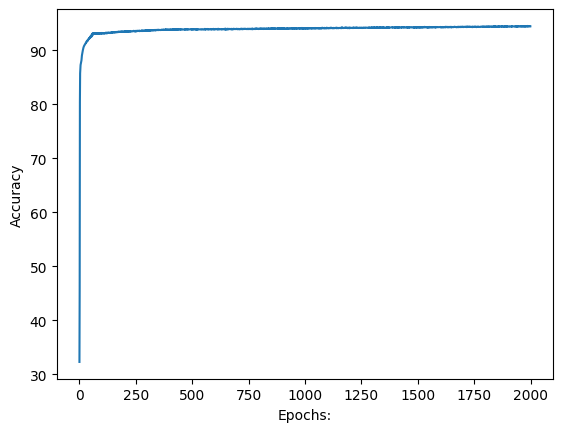

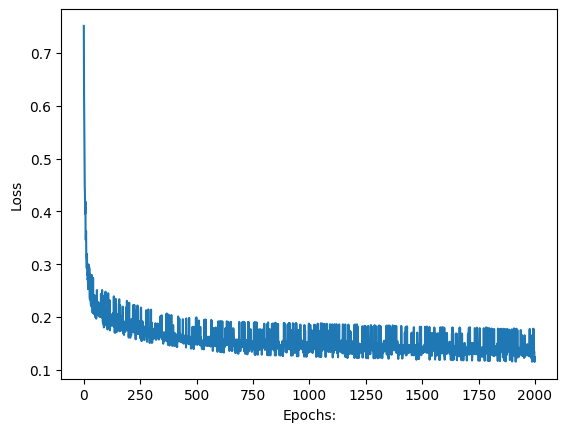

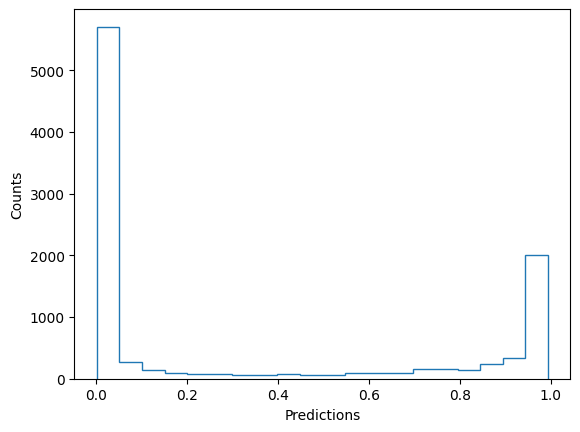

In [12]:
plt.plot(NetCE_Acc_train)
plt.ylabel('Accuracy')
plt.xlabel("Epochs:")
plt.show()
    
plt.plot(NetCE_Loss_train)
plt.ylabel('Loss')
plt.xlabel("Epochs:")
plt.show()

plt.hist(NetCE_Pred_val, histtype='step', bins=20)
plt.xlabel("Predictions")
plt.ylabel("Counts")
plt.show()

In [13]:
NetCE_Loss_train_norm, NetCE_Acc_train_norm, NetCE_Actual_train_norm, NetCE_Pred_train_norm = train(NetCE_norm, inputs=norm_dataset1_train, targets=bin_labels_train, 
                                                                            loss=BinCrossEntropy(), iterator=BatchIterator(batch_size=batch_num), num_epochs=2000)

NetCE_Loss_val_norm, NetCE_Acc_val_norm, NetCE_Actual_val_norm, NetCE_Pred_val_norm, NetCE_In_val_norm = validate(NetCE_norm, inputs=norm_dataset1_val, targets=bin_labels_val, 
                                                                       loss=BinCrossEntropy(), iterator=BatchIterator(batch_size=batch_num))

Epoch =  0  Loss =  0.8063068588328015  Acc =  32.295
Epoch =  100  Loss =  0.18769290754863494  Acc =  92.84
Epoch =  200  Loss =  0.15180217312424282  Acc =  94.35
Epoch =  300  Loss =  0.13423471062791298  Acc =  94.67
Epoch =  400  Loss =  0.15688848727740107  Acc =  94.875
Epoch =  500  Loss =  0.13210198414585717  Acc =  95.07
Epoch =  600  Loss =  0.12174572140476699  Acc =  95.165
Epoch =  700  Loss =  0.12046943429319205  Acc =  95.19
Epoch =  800  Loss =  0.14293275457128993  Acc =  95.3
Epoch =  900  Loss =  0.11302293432014969  Acc =  95.275
Epoch =  1000  Loss =  0.12140258786258744  Acc =  95.3
Epoch =  1100  Loss =  0.11464040478494317  Acc =  95.405
Epoch =  1200  Loss =  0.11924200946768548  Acc =  95.44500000000001
Epoch =  1300  Loss =  0.11671820211636842  Acc =  95.49
Epoch =  1400  Loss =  0.11510602460536679  Acc =  95.525
Epoch =  1500  Loss =  0.12124085560759933  Acc =  95.575
Epoch =  1600  Loss =  0.11374453610131022  Acc =  95.545
Epoch =  1700  Loss =  0.1

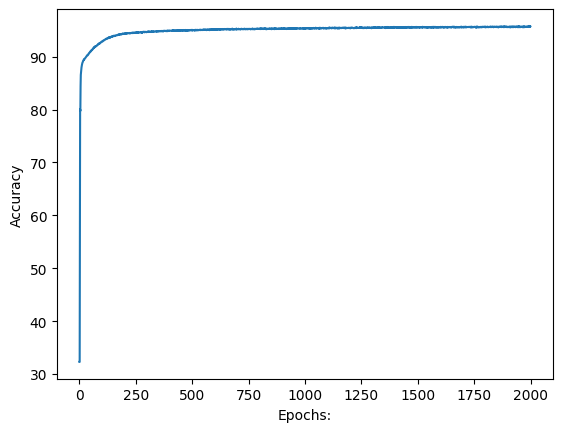

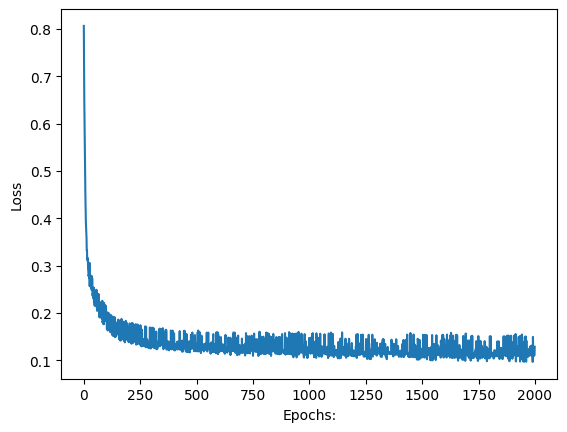

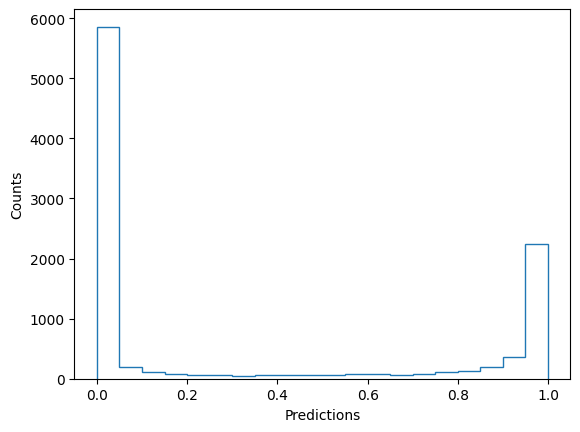

In [14]:
plt.plot(NetCE_Acc_train_norm)
plt.ylabel('Accuracy')
plt.xlabel("Epochs:")
plt.show()
    
plt.plot(NetCE_Loss_train_norm)
plt.ylabel('Loss')
plt.xlabel("Epochs:")
plt.show()

plt.hist(NetCE_Pred_val_norm, histtype='step', bins=20)
plt.xlabel("Predictions")
plt.ylabel("Counts")
plt.show()

In [15]:
NetMSE_Loss_train, NetMSE_Acc_train, NetMSE_Actual_train, NetMSE_Pred_train = train(NetMSE, inputs=norm_dataset1_train, targets=bin_labels_train,
                                                                            loss=MeanSquareError(), iterator=BatchIterator(batch_size=batch_num), num_epochs=2000)

NetMSE_Loss_val, NetMSE_Acc_val, NetMSE_Actual_val, NetMSE_Pred_val, NetMSE_In_val = validate(NetMSE, inputs=norm_dataset1_val, targets=bin_labels_val,
                                                                       loss=MeanSquareError(), iterator=BatchIterator(batch_size=batch_num))

Epoch =  0  Loss =  0.3327979248637288  Acc =  32.295
Epoch =  100  Loss =  0.07396131994153494  Acc =  90.53
Epoch =  200  Loss =  0.058093891468003124  Acc =  92.17
Epoch =  300  Loss =  0.053957890801910935  Acc =  93.37
Epoch =  400  Loss =  0.04223276223418978  Acc =  94.05
Epoch =  500  Loss =  0.04186859976681465  Acc =  94.41000000000001
Epoch =  600  Loss =  0.0413099292459379  Acc =  94.765
Epoch =  700  Loss =  0.03910579784726019  Acc =  94.98
Epoch =  800  Loss =  0.03808612290131015  Acc =  95.215
Epoch =  900  Loss =  0.03482216456585697  Acc =  95.31500000000001
Epoch =  1000  Loss =  0.036775874306739016  Acc =  95.455
Epoch =  1100  Loss =  0.040159821148809144  Acc =  95.505
Epoch =  1200  Loss =  0.031098960917656817  Acc =  95.69
Epoch =  1300  Loss =  0.03532868063521982  Acc =  95.755
Epoch =  1400  Loss =  0.03479722522097116  Acc =  95.785
Epoch =  1500  Loss =  0.032706398872618704  Acc =  95.81
Epoch =  1600  Loss =  0.03261230270867153  Acc =  95.89999999999

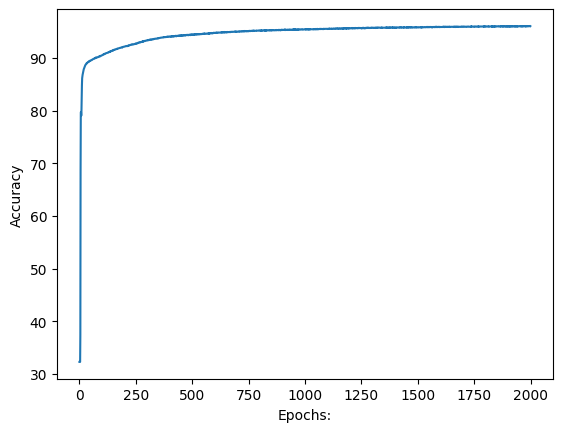

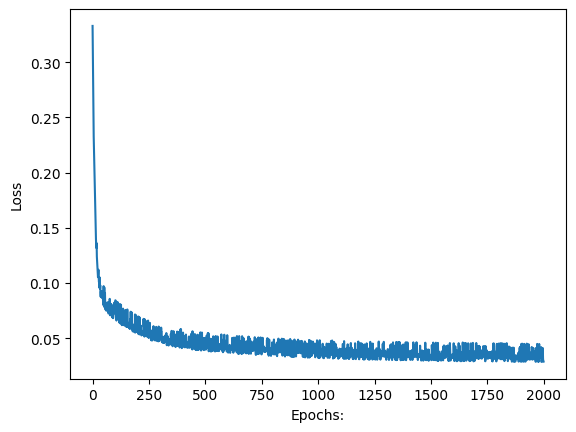

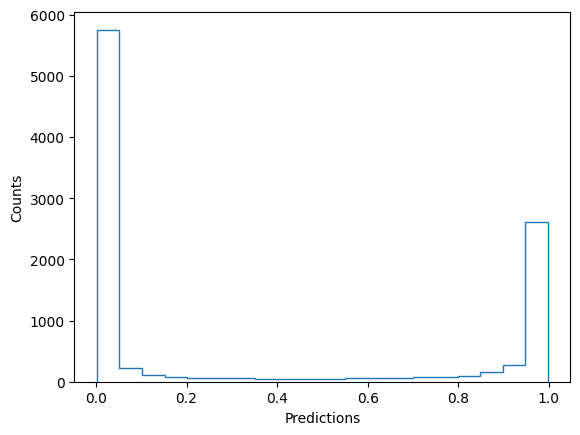

In [16]:
plt.plot(NetMSE_Acc_train)
plt.ylabel('Accuracy')
plt.xlabel("Epochs:")
plt.show()
    
plt.plot(NetMSE_Loss_train)
plt.ylabel('Loss')
plt.xlabel("Epochs:")
plt.show()

plt.hist(NetMSE_Pred_val, histtype='step', bins=20)
plt.xlabel("Predictions")
plt.ylabel("Counts")
plt.show()

In [17]:
""" epoch_range = np.arange(100, 5000, 100)

Acc_tot: Sequence = []
Loss_tot: Sequence = []
Pred_tot: Sequence = []

for N in epoch_range:

    net = NeuralNet([
        Linear(input_size=12, output_size=9, Seed=seed_value),
        Activation(tanh, tanh_prime),
        Linear(input_size=9, output_size=3, Seed=seed_value),
        Activation(tanh, tanh_prime),
        Linear(input_size=3, output_size=9, Seed=seed_value),
        Activation(tanh, tanh_prime),
        Linear(input_size=9, output_size=1, Seed=seed_value),
        Activation(sigmoid, sigmoid_prime),
    ])

    train(net, inputs=norm_dataset1_train, targets=bin_labels_train,
          loss=BinCrossEntropy(), iterator=BatchIterator(batch_size=batch_num), num_epochs=N, Print=False)

    net_Loss_val, net_Acc_val, net_Actual_val, net_Pred_val = validate(net, inputs=norm_dataset1_val, targets=bin_labels_val, 
                                                                        loss=BinCrossEntropy(), iterator=BatchIterator(batch_size=batch_num), Print=False)
    
    Acc_tot.append(net_Acc_val)
    Loss_tot.append(net_Loss_val)
    Pred_tot.append(net_Pred_val)
    

plt.plot(epoch_range, Acc_tot)
plt.ylabel(' Validation Accuracy')
plt.xlabel("Epochs:")
plt.show()

for p in Pred_tot:
    plt.hist(p, histtype='step', bins=20)
    plt.xlabel("Predictions")
    plt.ylabel("Counts")
plt.show() """


' epoch_range = np.arange(100, 5000, 100)\n\nAcc_tot: Sequence = []\nLoss_tot: Sequence = []\nPred_tot: Sequence = []\n\nfor N in epoch_range:\n\n    net = NeuralNet([\n        Linear(input_size=12, output_size=9, Seed=seed_value),\n        Activation(tanh, tanh_prime),\n        Linear(input_size=9, output_size=3, Seed=seed_value),\n        Activation(tanh, tanh_prime),\n        Linear(input_size=3, output_size=9, Seed=seed_value),\n        Activation(tanh, tanh_prime),\n        Linear(input_size=9, output_size=1, Seed=seed_value),\n        Activation(sigmoid, sigmoid_prime),\n    ])\n\n    train(net, inputs=norm_dataset1_train, targets=bin_labels_train,\n          loss=BinCrossEntropy(), iterator=BatchIterator(batch_size=batch_num), num_epochs=N, Print=False)\n\n    net_Loss_val, net_Acc_val, net_Actual_val, net_Pred_val = validate(net, inputs=norm_dataset1_val, targets=bin_labels_val, \n                                                                        loss=BinCrossEntropy(), it

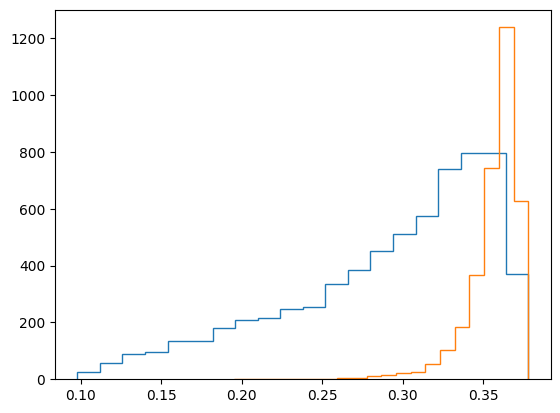

In [36]:
In_back: Sequence = []
Pred_back: Sequence = []
In_sig: Sequence = []
Pred_sig: Sequence = []

for i in range(0, len(NetCE_Pred_val_norm)):
    if np.round(NetCE_Pred_val_norm[i]) == 0:
        In_back.append(NetCE_In_val_norm[i])
        Pred_back.append(NetCE_Pred_val_norm[i])
    else:
        In_sig.append(NetCE_In_val_norm[i])
        Pred_sig.append(NetCE_Pred_val_norm[i])

In_back_arr = np.array(In_back)
Pred_back_arr = np.array(Pred_back)
In_sig_arr = np.array(In_sig)
Pred_sig_arr = np.array(Pred_sig)


plt.hist(In_back_arr[:, 11], histtype='step', bins=20)
plt.hist(In_sig_arr[:, 11], histtype='step', bins=20)
plt.show()

In [38]:
Acc_tot: Sequence = []
Acc_back_tot: Sequence = []
Acc_sig_tot: Sequence =[]
Loss_tot: Sequence = []
Pred_tot: Sequence = []

for N in range(10):

    net = NeuralNet([
        Linear(input_size=12, output_size=9, Seed=False),
        Activation(tanh, tanh_prime),
        Linear(input_size=9, output_size=3, Seed=False),
        Activation(tanh, tanh_prime),
        Linear(input_size=3, output_size=9, Seed=False),
        Activation(tanh, tanh_prime),
        Linear(input_size=9, output_size=1, Seed=False),
        Activation(sigmoid, sigmoid_prime),
    ])

    train(net, inputs=norm_dataset1_train, targets=bin_labels_train,
          loss=BinCrossEntropy(), iterator=BatchIterator(batch_size=batch_num), num_epochs=1000, Print=False)

    net_Loss_test, net_Acc_test, net_Actual_test, net_Pred_test, net_In_test = validate(net, inputs=norm_dataset1_test, targets=bin_labels_test, 
                                                                        loss=BinCrossEntropy(), iterator=BatchIterator(batch_size=batch_num), Print=False)
    
    Actual_back: Sequence = []
    Pred_back: Sequence = []
    Actual_sig: Sequence = []
    Pred_sig: Sequence = []

    for i in range(0, len(net_Actual_test)):
        if net_Actual_test[i] == 0:
            Actual_back.append(net_Actual_test[i])
            Pred_back.append(net_Pred_test[i])
        else:
            Actual_sig.append(net_Actual_test[i])
            Pred_sig.append(net_Pred_test[i])

    Actual_back_arr = np.array(Actual_back)
    Pred_back_arr = np.array(Pred_back)
    Actual_sig_arr = np.array(Actual_sig)
    Pred_sig_arr = np.array(Pred_sig)

    Acc_back = np.mean(Pred_back_arr.round()==Actual_back_arr) * 100
    Acc_sig = np.mean(Pred_sig_arr.round()==Actual_sig_arr) * 100
    
    Acc_tot.append(net_Acc_test)
    Acc_back_tot.append(Acc_back)
    Acc_sig_tot.append(Acc_sig)
    Loss_tot.append(net_Loss_test)
    Pred_tot.append(net_Pred_test)

    print("Acc = ", net_Acc_test, "Acc_back = ", Acc_back, "Acc_sig = ", Acc_sig)


Acc_back_arr = np.array(Acc_back_tot)
Acc_sig_arr = np.array(Acc_sig_tot)
Acc_array = np.array(Acc_tot)

Acc_final = np.mean(Acc_array)
Acc_back_final = np.mean(Acc_back_arr)
Acc_sig_final = np.mean(Acc_sig_arr)

print("Final mean Acc = ", Acc_final,", back mean Acc = ", Acc_back_final,", sig mean Acc = ", Acc_sig_final, ", Article Acc = ", Acc_article)


Acc =  92.42 Acc_back =  92.26486961617346 Acc_sig =  92.7536231884058
Acc =  92.5 Acc_back =  92.08907119835922 Acc_sig =  93.38374291115312
Acc =  91.89 Acc_back =  90.09668912979784 Acc_sig =  95.74669187145558
Acc =  92.2 Acc_back =  90.75593319660123 Acc_sig =  95.30560806553245
Acc =  90.97 Acc_back =  88.41195429241137 Acc_sig =  96.47132955261499
Acc =  92.05 Acc_back =  90.55083504248462 Acc_sig =  95.27410207939508
Acc =  92.58 Acc_back =  93.07061236448872 Acc_sig =  91.52488972904852
Acc =  91.57 Acc_back =  89.29094638148257 Acc_sig =  96.47132955261499
Acc =  92.21000000000001 Acc_back =  90.94638148256665 Acc_sig =  94.92753623188406
Acc =  92.61 Acc_back =  91.5616759449165 Acc_sig =  94.86452425960933
Final mean Acc =  92.1 , back mean Acc =  90.90389686492821 , sig mean Acc =  94.6723377441714 , Article Acc =  81.11
